In [56]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=3)
#
client = Client(cluster)




In [3]:
client

Client Scheduler: tcp://10.148.0.230:41822 Dashboard: http://10.148.0.230:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


#### Functions of loading, localization

In [4]:
def read_Ediag(V,diags):
    ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in diags])

    grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
    ds = xr.merge([ds,grid])
    #ds = ds#.isel(i = slice(0,None,4), j = slice(0,None,4), i_g = slice(0,None,4), j_g = slice(0,None,4))
    ds['lon'] = 0*ds.face+ds.XC
    ds['lat'] = 0*ds.face+ds.YC
    ds = ds.compute()
    # Rotation velocity field
    for diag in diags:
        ds['zonal_velocity_'+diag] =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.CS - ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.SN
        ds['meridional_velocity_'+diag] =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.SN + ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.CS

        ds['lon'] = 0*ds.face+ds.XC
        ds['lat'] = 0*ds.face+ds.YC
 #   ds = llcreader.faces_dataset_to_latlon(ds)
    return ds

In [5]:
def localize_Eulerian(bbox,ds,col):
    ds_sub = ds[col].where(np.logical_and(ds.lat<=bbox[3],ds.lat>=bbox[2]),drop=True).persist()
    ds_lon = ds['lon'].where(np.logical_and(ds.lat<=bbox[3],ds.lat>=bbox[2]),drop=True).persist()
    ds_lat = ds['lat'].where(np.logical_and(ds.lat<=bbox[3],ds.lat>=bbox[2]),drop=True).persist()
    ds_bis = xr.Dataset({'lon':ds_lon,col:ds_sub,'lat':ds_lat})
    ds_sub = ds_bis.where(np.logical_and(ds_bis.lon<=bbox[1],ds_bis.lon>=bbox[0]),drop=True).persist()
    #ds_sub = ds_sub.to_dataframe()
    #lon_E = ds_sub.lon[0,:,0]
    #lat_E = ds_sub.lat[0,0,:]
    #ds_E = xr.DataArray(ds_sub.isel(face=0)['zonal_velocity_mean'].values,dims=['lon','lat'],coords={'lon':lon_E.values,'lat':lat_E.values})
    return ds_sub

In [6]:
def localize_Lagrangian(bbox,df):
    df_sub = df[np.logical_and(df.lat<bbox[3],df.lat>bbox[2]
                                               )].persist()

    df_sub = df_sub[np.logical_and(df_sub.lon<bbox[1],df_sub.lon>bbox[0]
                                          )].persist()
    return df_sub

In [71]:
def func(ds,columns):
    ds_sub0 = localize_Eulerian(bbox,ds,columns[0])
    ds_sub0 = ds_sub0.drop(['face','CS','SN','XC','YC','rA','Depth'])
    df_E = ds_sub0.isel(face=0).to_dataframe()
    if len(columns)==1:
        return df_E
    else:
        for V in columns[1:]:
            ds_sub = localize_Eulerian(bbox,ds,V)
            ds_sub = ds_sub.drop(['face','CS','SN','XC','YC','rA','Depth'])
            df_E = df_E.merge(ds_sub.isel(face=0).to_dataframe())
        return df_E

In [43]:
def binned_mean(df,dl):
    """Average dataframe over bins width dl
    
    Parameters 
    df : dataframe with at least longitude, latitude and field to bin in columns
    dl : bin width
    
    Returns
    df_mean : dataset with averaged fields
    """
    lonmin,lonmax = df.lon.values.min(),df.lon.values.max()
    latmin,latmax = df.lat.values.min(),df.lat.values.max()
    lon = np.arange(lonmin,lonmax, dl)
    lat = np.arange(latmin, latmax, dl)
    df['lon_cut'] = pd.cut(df['lon'], lon)
    df['lat_cut'] = pd.cut(df['lat'], lat)
    df_mean = df.groupby(['lon_cut','lat_cut']).apply(lambda x:x.mean(skipna=False))
    df_mean = pa.add_geodata(df_mean)
    df_mean = (df_mean
     #     .drop(columns=['Coordinates'])
          .set_index(['lon', 'lat'])
         .to_xarray()
        )
    df_count = df.groupby(['lon_cut','lat_cut']).count()
    df_count = pa.add_geodata(df_count)
    df_count = (df_count
     #     .drop(columns=['Coordinates'])
          .set_index(['lon', 'lat'])
         .to_xarray()
        )
    df_mean['count'] = df_count.zonal_velocity_mean
    return df_mean

#### Functions for plotting

In [54]:
from shapely.geometry import Polygon
def plot_site(bbox,colmap='RdBu_r',figsize=(10,10)):

    central_lon = (bbox[0]+bbox[1])*0.5
    central_lat = (bbox[2]+bbox[3])*0.5

    polygon = Polygon([(bbox[0], bbox[2]), 
                       (bbox[1], bbox[2]), 
                       (bbox[1], bbox[3]), 
                       (bbox[0], bbox[3]), 
                       (bbox[0], bbox[2]),
                      ])
    #poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)
    gdf = tracks["swath"]
    gdf_clipped = gpd.clip(gdf, polygon)

    #crs = ccrs.Orthographic(central_lon, central_lat)
    crs = ccrs.AlbersEqualArea(central_lon, central_lat)

    crs_proj4 = crs.proj4_init

    fig, ax = plt.subplots(1, 1, 
                           subplot_kw={'projection': crs},
                           figsize=figsize,
                          )
    #ds_Lstats[V].plot(ax=ax,transform=ccrs.PlateCarree(),y='lat',vmax=vmax,cmap=colmap)
#    ax.set_extent(bbox)

    #_gdf = gdf.cx[bbox[0]:bbox[1], bbox[2]:bbox[3]]
    _gdf = gdf_clipped
    gdf_crs = _gdf.to_crs(crs_proj4)
    ax.add_geometries(gdf_crs['geometry'],
                      crs=crs,
                      facecolor='grey', 
                      edgecolor='black',
                      alpha=0.5,
                     )

    ax.gridlines(draw_labels=True)
#    ax.coastlines(resolution='50m')
    ax.set_extent(bbox)
    return fig, ax

In [72]:
def plot_swot(df,col,colmap):
    fig,ax = plot_site(bbox,figsize=(10,10))
    df.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat',c=col,s=5,cmap=colmap)

In [38]:
def binned_site(bbox,df,dl,V):
    df_sub = df[np.logical_and(df.lat<bbox[3],df.lat>bbox[2]
                                               )].persist()

    df_sub = df[np.logical_and(df.lon<bbox[1],df.lon>bbox[0]
                                          )].persist()
    lon = np.arange(bbox[0],bbox[1], dl)
    lat = np.arange(bbox[-2], bbox[-1], dl)
    df_sub['lon'] = (df_sub['lon']+180)%360 - 180
    df_sub['lon_cut'] = df_sub['lon'].map_partitions(pd.cut, lon)
    df_sub['lat_cut'] = df_sub['lat'].map_partitions(pd.cut, lat)
    df_sub = df_sub.persist()
    uv_sub = df_sub.groupby(['lon_cut','lat_cut']).mean(skipna=False).compute()
    return uv_sub

In [9]:
ds = ut.load_data(['SSU','SSV'])

In [10]:
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 8785)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ... 2012-11-15
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    SSU      (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSV      (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

In [8]:
# Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = p.df['time_mean']

df = pa.degs2ms(df) #Convert in m/s 

df = df.persist()

In [9]:
df = df.drop(columns=['temperature','sea_level','salinity','SST_interp','SSS_interp','Eta_interp'])
df = df.rename(columns={'SSU_interp':'zonal_velocity_mean','SSV_interp':'meridional_velocity_mean'})

In [10]:
df= df.persist()

In [11]:
# Eulerian data
V = ["SSU","SSV"]#["SSU", "SSV"]
D = ["mean"]#, "prime_mean","prime_mean_sq"]
ds = read_Ediag(V,D)

In [13]:
tracks = ut.load_swot_tracks()

#### California

In [24]:
bbox = [-128, -120, 33, 38] # small bbox
dl = 1.

In [25]:
df_sub = localize_Lagrangian(bbox,df)

In [26]:
df_sub = df_sub.compute()

In [27]:
ds_sub = localize_Eulerian(bbox,ds,'zonal_velocity_mean')

In [28]:
ds_sub_V = localize_Eulerian(bbox,ds,'meridional_velocity_mean')

In [29]:
ds_sub = ds_sub.drop(['face','CS','SN','XC','YC','rA','Depth'])#.plot.scatter()
ds_sub_V = ds_sub_V.drop(['face','CS','SN','XC','YC','rA','Depth'])

In [30]:
df_E = ds_sub.isel(face=0).to_dataframe()
df_EV = ds_sub_V.isel(face=0).to_dataframe()

In [31]:
df_E = df_E.merge(df_EV)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


Text(0.5, 0.98, 'Scatter plot')

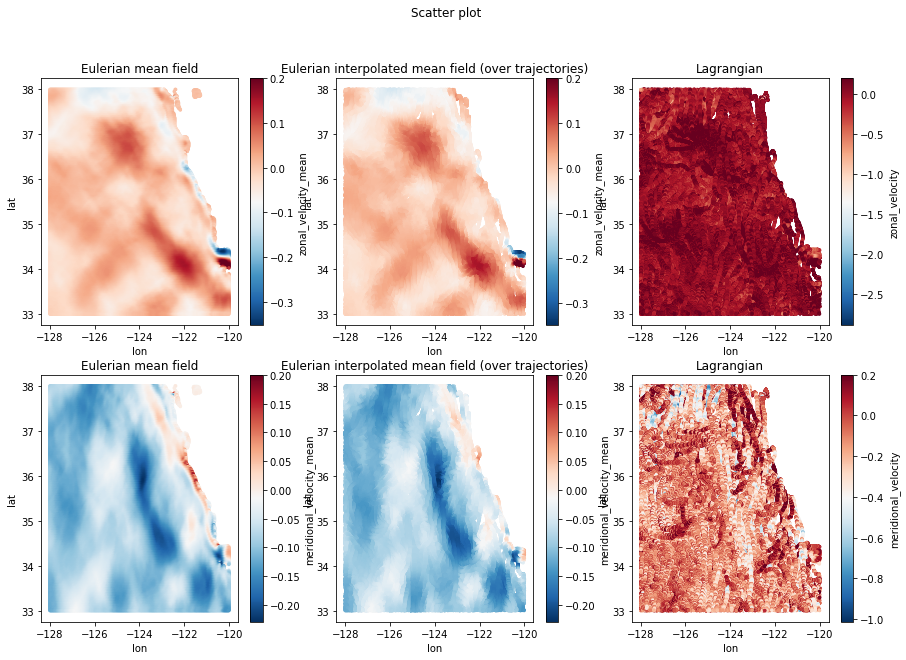

In [37]:
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i,V in enumerate(['zonal_velocity_mean','meridional_velocity_mean']):
    df_E.plot.scatter(x='lon',y='lat',c=V,cmap='RdBu_r',ax=axs[i,0],s=6,vmax=0.2)
    df_sub.plot.scatter(x='lon',y='lat',c=V,cmap='RdBu_r',ax=axs[i,1],s=6,vmax=0.2)
    df_sub.plot.scatter(x='lon',y='lat',c=V.split('_m')[0],cmap='RdBu_r',ax=axs[i,2],s=6,vmax=0.2)

    for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs[i,:]):
        ax.set_title(title)

fig.suptitle('Scatter plot')

In [44]:
dfE_1dl = binned_mean(df_E,dl)
dfL_1dl = binned_mean(df_sub,dl)

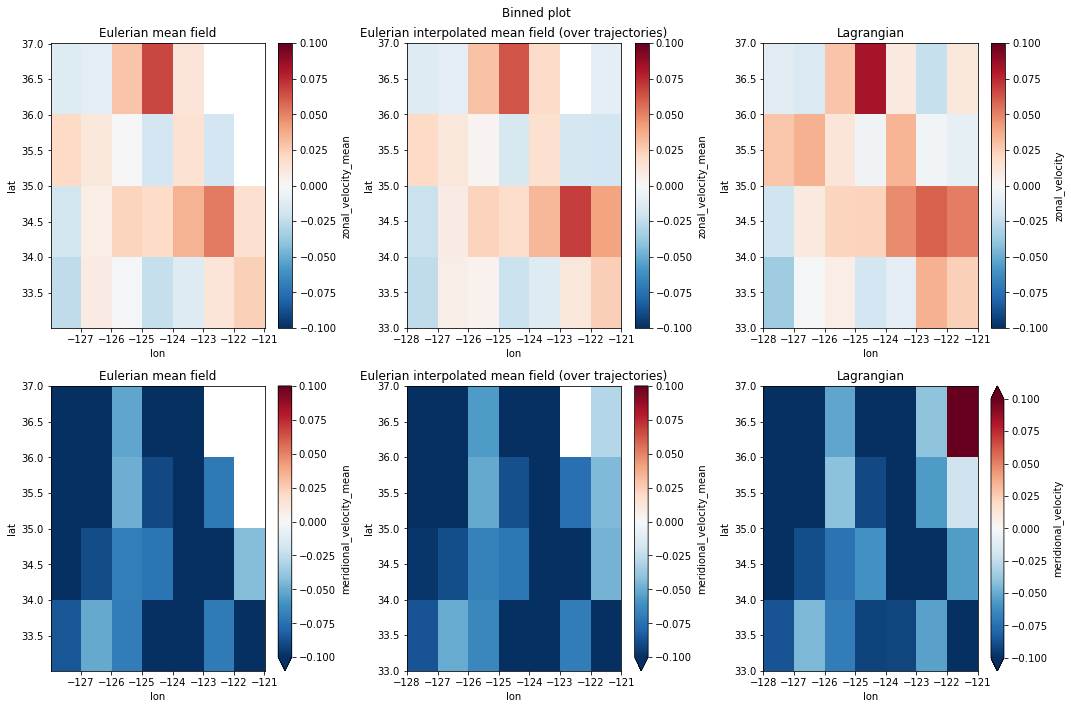

In [45]:
vmax = 0.1
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i,V in enumerate(['zonal_velocity_mean','meridional_velocity_mean']):
    dfE_1dl[V].plot(x='lon',y='lat',cmap='RdBu_r',ax=axs[i,0],vmax=vmax)
    dfL_1dl[V].plot(x='lon',y='lat',cmap='RdBu_r',ax=axs[i,1],vmax=vmax)
    dfL_1dl[V.split('_m')[0]].plot(x='lon',y='lat',cmap='RdBu_r',ax=axs[i,2],vmax=vmax)

    for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs[i,:]):
        ax.set_title(title)

fig.suptitle('Binned plot')
fig.tight_layout()


In [51]:
dfE_1dl = dfE_1dl.assign_coords({'lon':dfL_1dl.lon.values,'lat':dfL_1dl.lat.values})

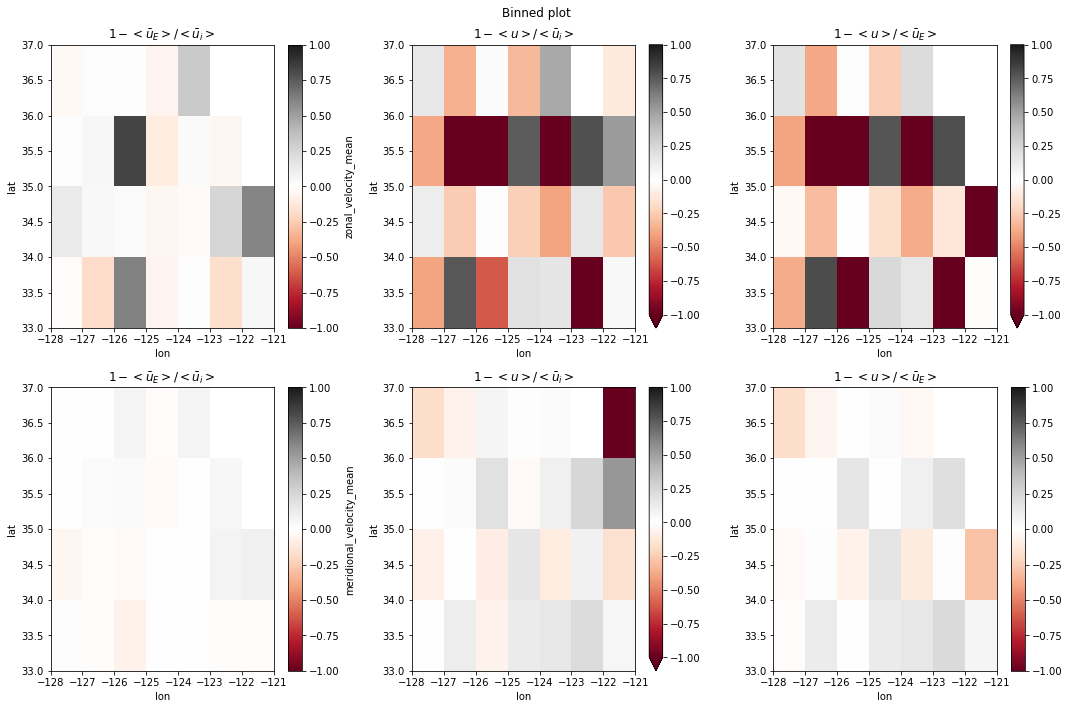

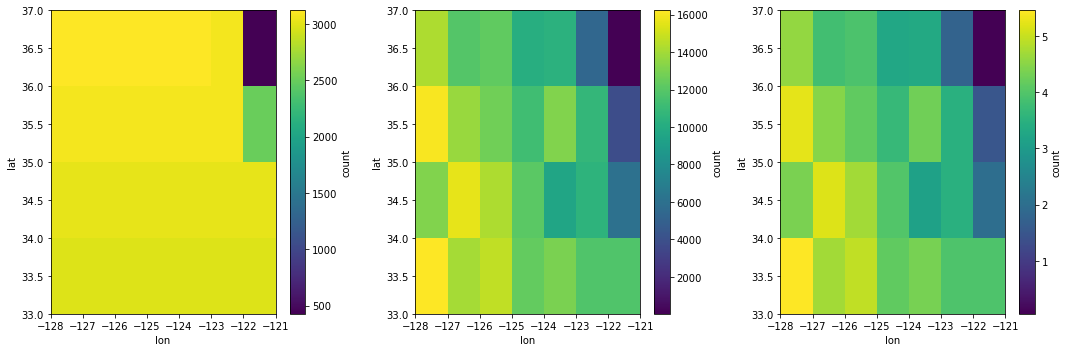

In [52]:
cmap='RdGy'
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i,V in enumerate(['zonal_velocity_mean','meridional_velocity_mean']):
    (1-np.abs(dfE_1dl[V]/dfL_1dl[V])).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,0],vmax=1)
    (1-np.abs(dfL_1dl[V.split('_m')[0]]/dfL_1dl[V])).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,1],vmax=1)
    (1-np.abs(dfL_1dl[V.split('_m')[0]]/dfE_1dl[V])).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,2],vmax=1)

    for title,ax in zip([r'$1-<\bar u_E>/<\bar u_i>$',r'$1-<u>/<\bar u_i>$',r'$1-<u>/<\bar u_E>$'],axs[i,:]):
        ax.set_title(title)

fig.suptitle('Binned plot')
fig.tight_layout()
fig,ax = plt.subplots(1,3,figsize=(15,5))
dfE_1dl['count'].plot(y='lat',ax=ax[0])
dfL_1dl['count'].plot(y='lat',ax=ax[1])
(dfL_1dl['count']/dfE_1dl['count']).plot(y='lat',ax=ax[2])
fig.tight_layout()

#### Notes (figure interpretation) : 
Left column : 

1) values smaller than 0 <=> Eulerian values higher than Eulerian interpolated values
2) 0<values<1 <=> Eulerian values smaller than Eulerian interpolated values
3) values=0 <=> Eulerian values equal Eulerian interpolated values

Middle column : 

1) values smaller than 0 <=> Lagrangian values higher than Eulerian interpolated values
2) 0<values<1 <=> Lagrangian values smaller than Eulerian interpolated values
3) values=0 <=> Lagrangian values equal Eulerian interpolated values

Right column : 

1) values smaller than 0 <=> Lagrangian values higher than Eulerian values
2) 0<values<1 <=> Lagrangian values smaller than Eulerian values
3) values=0 <=> Lagrangian values equal Eulerian values

<GeoAxesSubplot:xlabel='lon', ylabel='lat'>

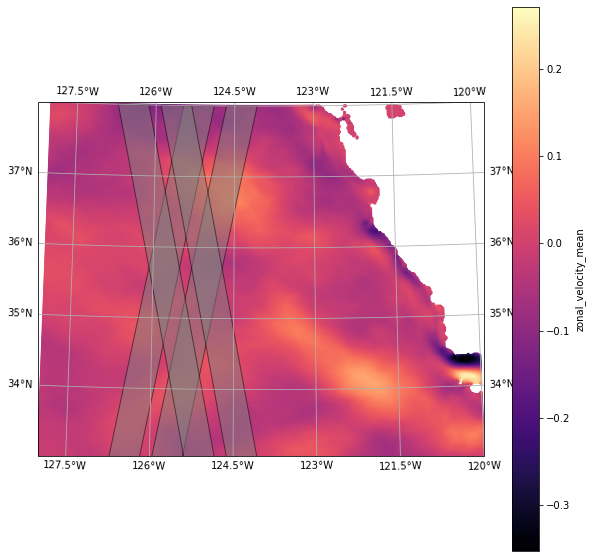

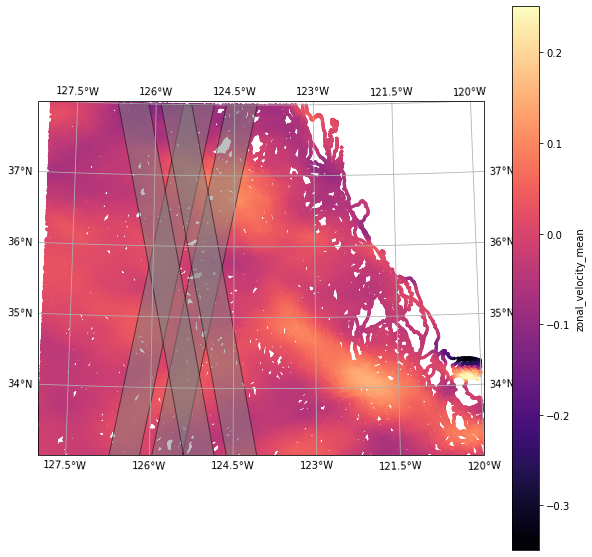

In [65]:

colmap='magma'
fig,ax = plot_site(bbox,colmap=colmap);
df_E.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat',c='zonal_velocity_mean',s=5,cmap=colmap)

fig,ax = plot_site(bbox,colmap=colmap);
df_sub.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat',c='zonal_velocity_mean',s=5,cmap=colmap)

In [66]:
bbox = [-2, 8, 36, 45] # large bbox

In [ ]:
df_sub = localize_Lagrangian(bbox,df)

In [68]:
cluster.close()

KeyboardInterrupt: 